## Forcasting in Engineering und Managemen

## Bitcoin Price Analysis

This project analyzes the daily closing prices of Bitcoin (BTC-USD) over a customizable time range using data retrieved dynamically from Yahoo Finance via the `yfinance` package.

# Project Objectives:
- Perform **Exploratory Data Analysis (EDA)** to understand distribution, trends, and volatility.
- Apply **stationarity checks** using the Augmented Dickey-Fuller test.
- Decompose the series into **trend, seasonality, and residuals**.
- Use **ACF and PACF** plots to guide ARIMA model selection.

# Key Features:
- Fully dynamic: change `TIME_SPAN_DAYS` and `INTERVAL` to switch between daily, weekly, monthly, etc.
- Integrated visualization with Matplotlib and Seaborn.
- Forecast-ready: Stationary transformation is applied where necessary.
- Ideal for coursework in **Forecasting in Engineering & Management (FoEM)**.


>  *Note: All price data is fetched live using `yfinance`, ensuring up-to-date results and eliminating the need for static CSV files.*


In [172]:
# Imports

import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose

In [173]:
# CONFIGURATION (Universal)
TIME_SPAN_DAYS = 364       # Change this to 30, 100, 1000, etc.
INTERVAL = "1d"            # Options: '1d', '1wk', '1mo'

# ALLOWED INTERVALS and their meanings:
# '1d'   = daily
# '1wk'  = weekly
# '1mo'  = monthly
# Yahoo Finance does NOT support minutely/hourly for BTC

In [174]:
def fetch_btc_data(days=TIME_SPAN_DAYS, interval=INTERVAL):
    """
    Fetch BTC-USD from Yahoo Finance with MultiIndex flattening.
    Returns: DataFrame with 'timestamp' and 'price'
    """
    end = datetime.today()
    start = end - pd.Timedelta(days=days)

    df = yf.download("BTC-USD", start=start, end=end, interval=interval)

    if df.empty:
        print(" No data returned.")
        return pd.DataFrame()

    #  Flatten MultiIndex (Price, Ticker) → "Close BTC-USD"
    df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    #  Reset index to access 'Date'
    df = df.reset_index()

    #  Rename columns
    if "Date" in df.columns and "Close BTC-USD" in df.columns:
        df = df.rename(columns={"Date": "timestamp", "Close BTC-USD": "price"})
    else:
        print(" Columns not found after flattening.")
        return pd.DataFrame()

    #  Clean up
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df = df.dropna(subset=["price", "timestamp"])

    print(f" Cleaned data shape: {df.shape} | Interval: {interval} | Days: {days}")
    return df

In [175]:
btc_df = fetch_btc_data()
btc_df.head()

[*********************100%***********************]  1 of 1 completed

 Cleaned data shape: (365, 6) | Interval: 1d | Days: 364


,timestamp,price,High BTC-USD,Low BTC-USD,Open BTC-USD,Volume BTC-USD
0,2024-06-18,65140.746094,66556.703125,64066.957031,66490.976562,39481285950
1,2024-06-19,64960.296875,65695.351562,64693.300781,65146.660156,21103423504
2,2024-06-20,64828.656250,66438.960938,64547.847656,64960.296875,25641109124
3,2024-06-21,64096.199219,65007.546875,63378.894531,64837.988281,26188171739
4,2024-06-22,64252.578125,64475.468750,63929.757812,64113.863281,9858198793


In [176]:
btc_df.describe()

,timestamp,price,High BTC-USD,Low BTC-USD,Open BTC-USD,Volume BTC-USD
count,365,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,2024-12-17 00:00:00,82519.950878,83973.672057,80850.509161,82416.155918,4.285257e+10
min,2024-06-18 00:00:00,53948.753906,54838.144531,49121.238281,53949.085938,9.858199e+09
25%,2024-09-17 00:00:00,64178.992188,65007.546875,62873.617188,64176.367188,2.747094e+10
50%,2024-12-17 00:00:00,85063.414062,86522.304688,83647.195312,84900.187500,3.748878e+10
75%,2025-03-18 00:00:00,97437.554688,98935.031250,95765.343750,97438.132812,5.182343e+10
max,2025-06-17 00:00:00,111673.281250,111970.171875,109285.070312,111679.359375,1.492189e+11
std,NaN,17449.875941,17638.212384,17172.958045,17431.986142,2.341553e+10


In [177]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       365 non-null    datetime64[ns]
 1   price           365 non-null    float64       
 2   High BTC-USD    365 non-null    float64       
 3   Low BTC-USD     365 non-null    float64       
 4   Open BTC-USD    365 non-null    float64       
 5   Volume BTC-USD  365 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 17.2 KB


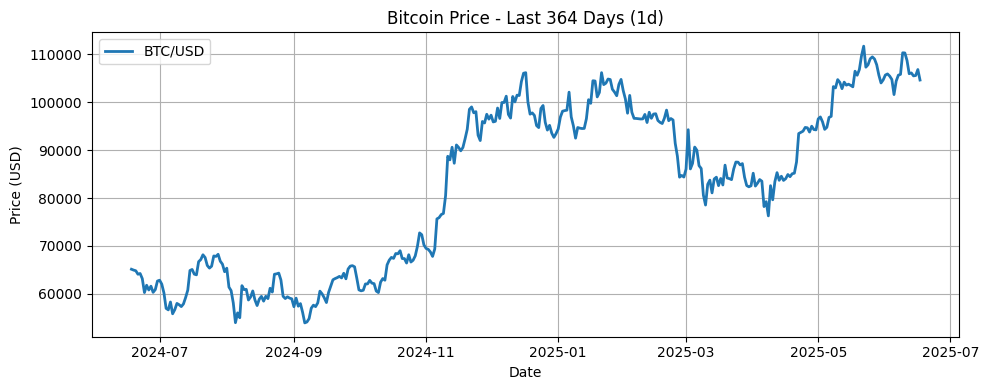

 Summary from 2024-06-18 to 2025-06-17:
- Min price:  $53,948.75
- Max price:  $111,673.28
- Mean price: $82,519.95


In [178]:
def plot_btc_price(df, title=None):
    """
    Plot BTC price over time and print summary stats.
    """
    if df.empty:
        print("No data to plot.")
        return

    if title is None:
        title = f"Bitcoin Price - Last {TIME_SPAN_DAYS} Days ({INTERVAL})"

    plt.figure(figsize=(10, 4))
    plt.plot(df["timestamp"], df["price"], label="BTC/USD", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Text summary
    print(f" Summary from {df['timestamp'].iloc[0].date()} to {df['timestamp'].iloc[-1].date()}:")
    print(f"- Min price:  ${df['price'].min():,.2f}")
    print(f"- Max price:  ${df['price'].max():,.2f}")
    print(f"- Mean price: ${df['price'].mean():,.2f}")


plot_btc_price(btc_df)



Summary Statistics for BTC Prices:

count       365.000000
mean      82519.950878
std       17449.875941
min       53948.753906
25%       64178.992188
50%       85063.414062
75%       97437.554688
max      111673.281250
Name: price, dtype: float64


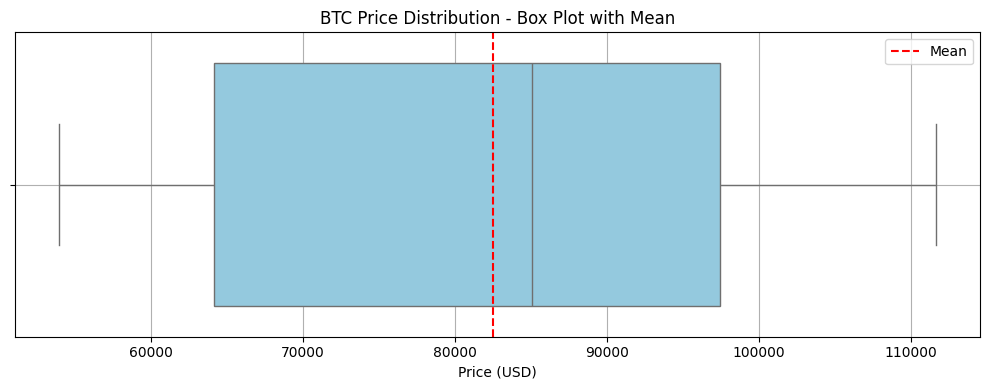

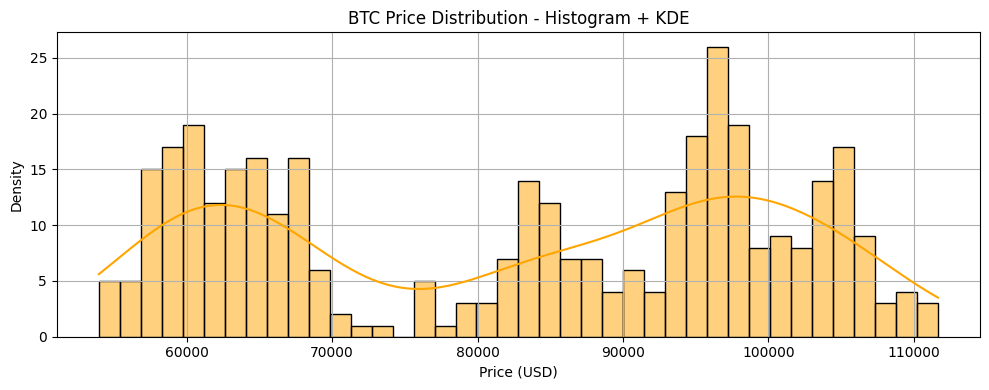

In [179]:
# Ensure timestamp is datetime and set as index
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])
btc_df = btc_df.set_index('timestamp')

# 1. Summary Stats
print("Summary Statistics for BTC Prices:\n")
print(btc_df['price'].describe())

# 2. Box Plot with Mean
plt.figure(figsize=(10, 4))
sns.boxplot(x=btc_df['price'], color='skyblue')
plt.axvline(btc_df['price'].mean(), color='red', linestyle='--', label='Mean')
plt.title("BTC Price Distribution - Box Plot with Mean")
plt.xlabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram with KDE
plt.figure(figsize=(10, 4))
sns.histplot(btc_df['price'], kde=True, bins=40, color='orange')
plt.title("BTC Price Distribution - Histogram + KDE")
plt.xlabel("Price (USD)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

The BTC price is slightly right-skewed, with a median below the mean and several high-value outliers pushing the distribution upward.

The distribution is bimodal, suggesting two dominant price clusters — likely representing two different market phases over the year.

C:\Users\Asus\AppData\Local\Temp\ipykernel_14548\1337390418.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = btc_df['price'].resample('M').mean()


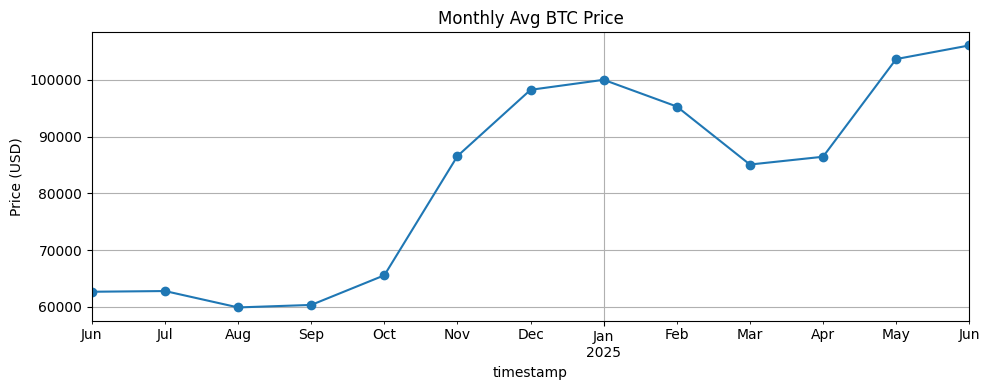

Monthly Average:
 timestamp
2024-06-30     62680.247296
2024-07-31     62804.542087
2024-08-31     59921.197581
2024-09-30     60358.515885
2024-10-31     65577.264491
2024-11-30     86570.707812
2024-12-31     98232.948589
2025-01-31     99992.847782
2025-02-28     95290.709542
2025-03-31     85075.980091
2025-04-30     86447.715104
2025-05-31    103644.514869
2025-06-30    106044.862592
Freq: ME, Name: price, dtype: float64


In [180]:
# Monthly Average BTC Price
monthly_avg = btc_df['price'].resample('M').mean()
monthly_stats = monthly_avg.describe()
monthly_avg.plot(marker='o', figsize=(10, 4), title='Monthly Avg BTC Price')
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Monthly Average:\n", monthly_avg)

Bitcoin experienced a strong upward trend from October through December, followed by short-term fluctuations in early 2025 before rising again in May and June.

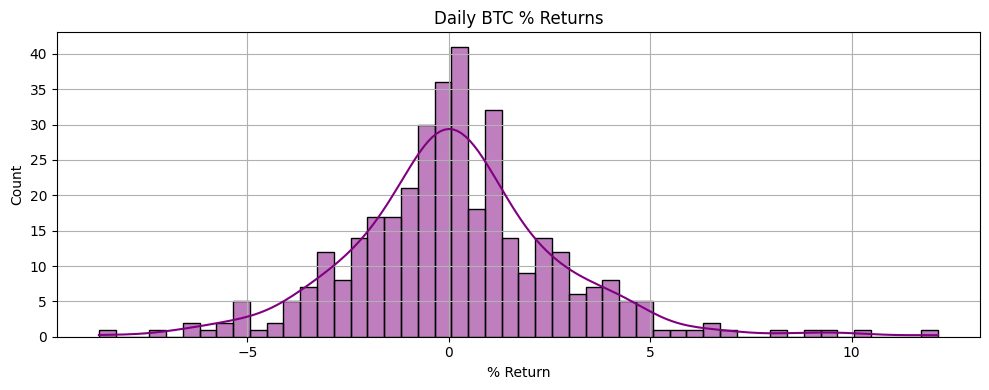

Return:
 timestamp
2024-06-19   -0.277014
2024-06-20   -0.202648
2024-06-21   -1.129835
2024-06-22    0.243975
2024-06-23   -1.668075
                ...   
2025-06-13    0.152851
2025-06-14   -0.583049
2025-06-15    0.075486
2025-06-16    1.179262
2025-06-17   -2.047742
Name: price, Length: 364, dtype: float64


In [181]:
# Daily Returns
returns = btc_df['price'].pct_change().dropna() * 100
returns_stats = returns.describe()
plt.figure(figsize=(10, 4))
sns.histplot(returns, bins=50, kde=True, color='purple')
plt.title("Daily BTC % Returns")
plt.xlabel("% Return")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Return:\n", returns)

Daily returns represent the percentage change in price from one day to the next, measuring short-term market fluctuations.

Interpretation:
Returns are centered around zero with a slight negative skew, indicating that while most price changes are small, sharp drops occur more frequently than large gains — a sign of asymmetrical volatility.

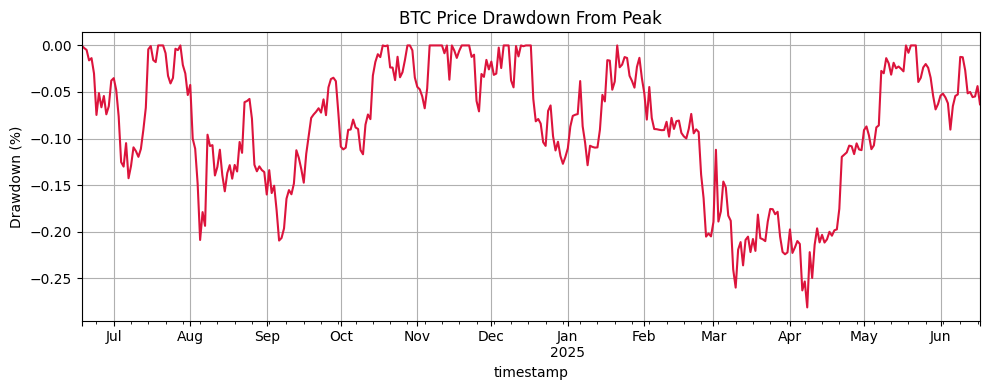

Drawdown 
 timestamp
2024-06-18    0.000000
2024-06-19   -0.002770
2024-06-20   -0.004791
2024-06-21   -0.016035
2024-06-22   -0.013635
                ...   
2025-06-13   -0.049988
2025-06-14   -0.055527
2025-06-15   -0.054814
2025-06-16   -0.043668
2025-06-17   -0.063251
Name: drawdown, Length: 365, dtype: float64


In [182]:
# Drawdown
btc_df['cum_max'] = btc_df['price'].cummax()
btc_df['drawdown'] = btc_df['price'] / btc_df['cum_max'] - 1
drawdown_stats = btc_df['drawdown'].describe()
plt.figure(figsize=(10, 4))
btc_df['drawdown'].plot(color='crimson')
plt.title("BTC Price Drawdown From Peak")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Drawdown \n", btc_df['drawdown'])

Drawdown measures how much the price has declined from its historical peak, reflecting temporary losses before a recovery.

Multiple sharp drawdowns are observed, especially around September and March, indicating brief bearish phases within an otherwise overall bullish year.

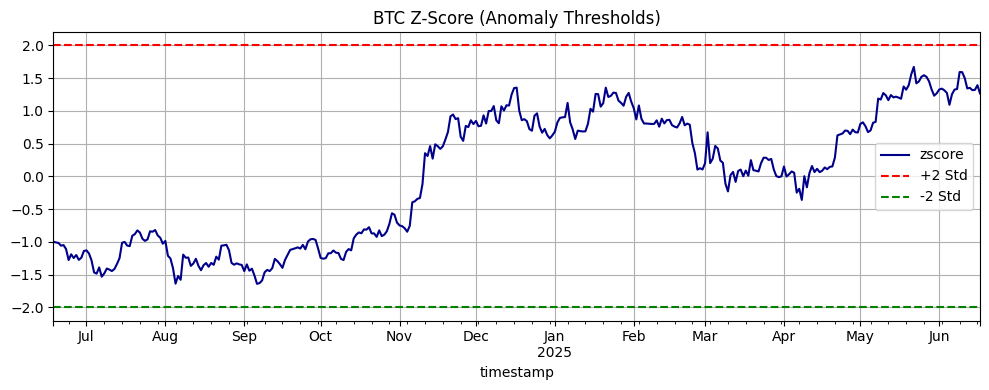

 Z-Score 
 timestamp
2024-06-18   -0.997317
2024-06-19   -1.007672
2024-06-20   -1.015227
2024-06-21   -1.057259
2024-06-22   -1.048285
                ...   
2025-06-13    1.352638
2025-06-14    1.317142
2025-06-15    1.321711
2025-06-16    1.393141
2025-06-17    1.267643
Name: zscore, Length: 365, dtype: float64


In [183]:
# Z-Score
btc_df['zscore'] = zscore(btc_df['price'])
zscore_stats = btc_df['zscore'].describe()
plt.figure(figsize=(10, 4))
btc_df['zscore'].plot(color='darkblue')
plt.axhline(2, color='red', linestyle='--', label='+2 Std')
plt.axhline(-2, color='green', linestyle='--', label='-2 Std')
plt.title("BTC Z-Score (Anomaly Thresholds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Z-Score \n", btc_df['zscore'])

The Z-score standardizes prices by measuring how many standard deviations a value is from the mean. It is used for anomaly detection.

BTC generally stayed within ±2 standard deviations (normal range), but moved beyond that during the steep rally in November–December, signaling price surges that were statistically unusual

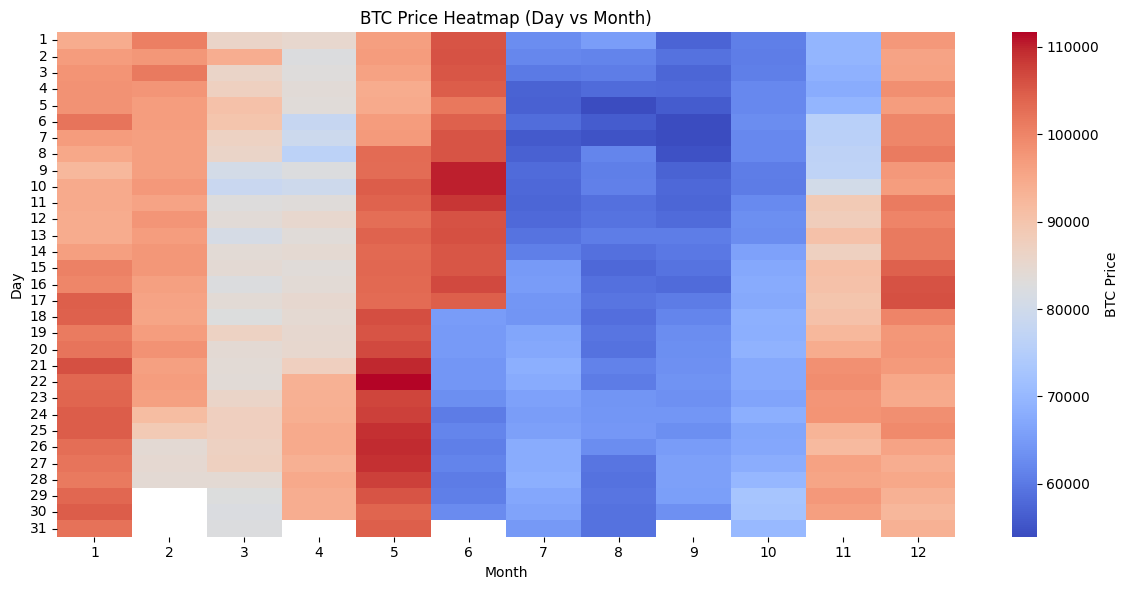

In [184]:
# Heatmap (Day vs Month)
btc_df['month'] = btc_df.index.month
btc_df['day'] = btc_df.index.day
pivot = btc_df.pivot_table(values='price', index='day', columns='month')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='coolwarm', cbar_kws={'label': 'BTC Price'})
plt.title("BTC Price Heatmap (Day vs Month)")
plt.xlabel("Month")
plt.ylabel("Day")
plt.tight_layout()
plt.show()

BTC prices were consistently higher in May and December, while August through October saw weaker performance — hinting at seasonal or cyclical investor behavior.

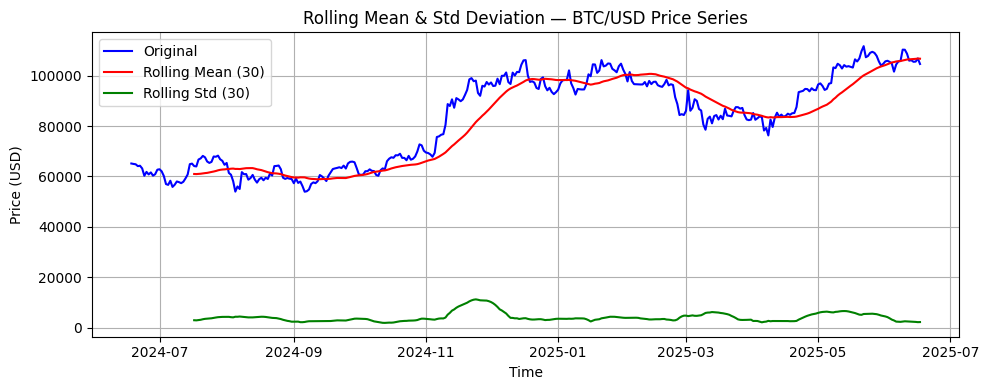


 ADF Test Results:
- ADF Statistic: -1.0230
- p-value: 0.7448
- Critical Value (1%): -3.4484
- Critical Value (5%): -2.8695
- Critical Value (10%): -2.5710
 Likely NON-STATIONARY (fail to reject H0)


In [185]:
def check_stationarity(series, window=30, title="BTC Price Series"):
    """
    Plot rolling stats and perform ADF test to check stationarity.
    """
    if series.isnull().all():
        print(" Series is empty or fully NaN.")
        return

    # Rolling mean & std
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()

    plt.figure(figsize=(10, 4))
    plt.plot(series, label="Original", color='blue')
    plt.plot(rolling_mean, label=f"Rolling Mean ({window})", color='red')
    plt.plot(rolling_std, label=f"Rolling Std ({window})", color='green')
    plt.title(f"Rolling Mean & Std Deviation — {title}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ADF Test
    print("\n ADF Test Results:")
    result = adfuller(series.dropna())
    print(f"- ADF Statistic: {result[0]:.4f}")
    print(f"- p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"- Critical Value ({key}): {value:.4f}")

    if result[1] < 0.05:
        print(" Likely STATIONARY (reject H0)")
    else:
        print(" Likely NON-STATIONARY (fail to reject H0)")


check_stationarity(btc_df["price"], window=30, title="BTC/USD Price Series")


The visible upward trend in the rolling mean and fluctuating standard deviation over time indicate non-stationarity in the data. This visual instability suggests that the statistical properties (mean and variance) of the series are not constant over time.

The (ADF) test returned a statistic of -1.0278 with a p-value of 0.7430. Since the p-value is well above the 0.05 threshold and the test statistic does not fall below any of the critical values, we fail to reject the null hypothesis. Therefore, the original BTC price series is likely non-stationary.

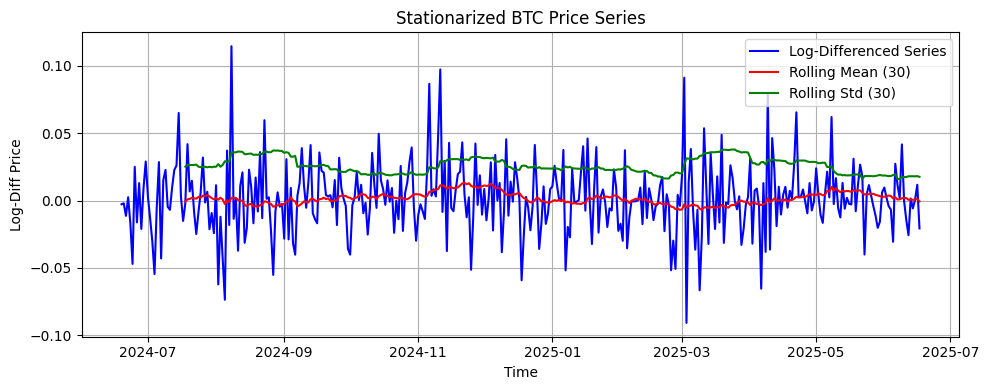

 ADF Test on Log-Differenced Series:
- ADF Statistic: -19.9791
- p-value: 0.0000
- Critical Value (1%): -3.4485
- Critical Value (5%): -2.8695
- Critical Value (10%): -2.5710
 Now STATIONARY (reject H0)


In [186]:
def make_stationary(df, column="price", window=30):
    """
    Apply log and differencing to make the series stationary.
    Then perform ADF test and plot rolling stats.
    """
    # Step 1: Log transform
    log_series = np.log(df[column])
    
    # Step 2: First-order differencing
    diff_series = log_series.diff().dropna()
    
    # Step 3: Rolling stats plot
    rolling_mean = diff_series.rolling(window).mean()
    rolling_std = diff_series.rolling(window).std()

    plt.figure(figsize=(10, 4))
    plt.plot(diff_series, label="Log-Differenced Series", color='blue')
    plt.plot(rolling_mean, label=f"Rolling Mean ({window})", color='red')
    plt.plot(rolling_std, label=f"Rolling Std ({window})", color='green')
    plt.title("Stationarized BTC Price Series")
    plt.xlabel("Time")
    plt.ylabel("Log-Diff Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 4: ADF Test
    print(" ADF Test on Log-Differenced Series:")
    result = adfuller(diff_series)
    print(f"- ADF Statistic: {result[0]:.4f}")
    print(f"- p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"- Critical Value ({key}): {value:.4f}")

    if result[1] < 0.05:
        print(" Now STATIONARY (reject H0)")
    else:
        print(" Still NON-STATIONARY")

    return diff_series



btc_stationary = make_stationary(btc_df, column="price", window=30)


After applying a log transformation and first-order differencing to remove trend and stabilize variance, the resulting series appears visually stationary. The rolling mean and standard deviation become stable and constant over time.

The ADF test on the log-differenced series returned a statistic of -19.9777 with a p-value of 0.0000. The test statistic is well below all critical values, and the p-value is below the 0.05 threshold.

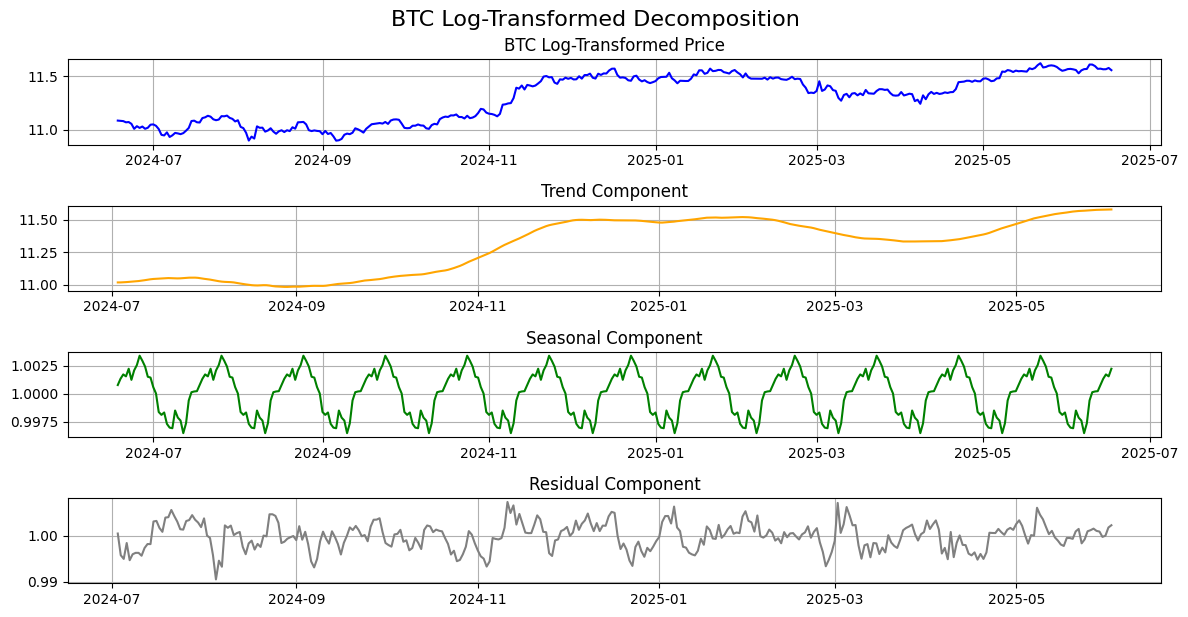

In [187]:
def decompose_series_clean(df, column="price", model="multiplicative", period=30):
    """
    Decompose log-transformed series and create a clean, annotated plot.
    """

    log_series = np.log(df[column])
    result = seasonal_decompose(log_series, model=model, period=period)

    # Extract components
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid

    # Plot clean
    plt.figure(figsize=(12, 6))

    plt.subplot(411)
    plt.plot(log_series, label="Log Price", color="blue")
    plt.title("BTC Log-Transformed Price")
    plt.grid(True)

    plt.subplot(412)
    plt.plot(trend, label="Trend", color="orange")
    plt.title("Trend Component")
    plt.grid(True)

    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality", color="green")
    plt.title("Seasonal Component")
    plt.grid(True)

    plt.subplot(414)
    plt.plot(resid, label="Residuals", color="gray")
    plt.title("Residual Component")
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle("BTC Log-Transformed Decomposition", fontsize=16, y=1.02)
    plt.show()

    return result


decomposition_result = decompose_series_clean(btc_df, column="price", model="multiplicative", period=30)


The decomposition of the log-transformed BTC series reveals clear trend and seasonal components. The trend increases steadily through late 2024 and early 2025, while the seasonal component displays a strong and regular cyclical pattern. The residual component shows minor noise after removing trend and seasonality.

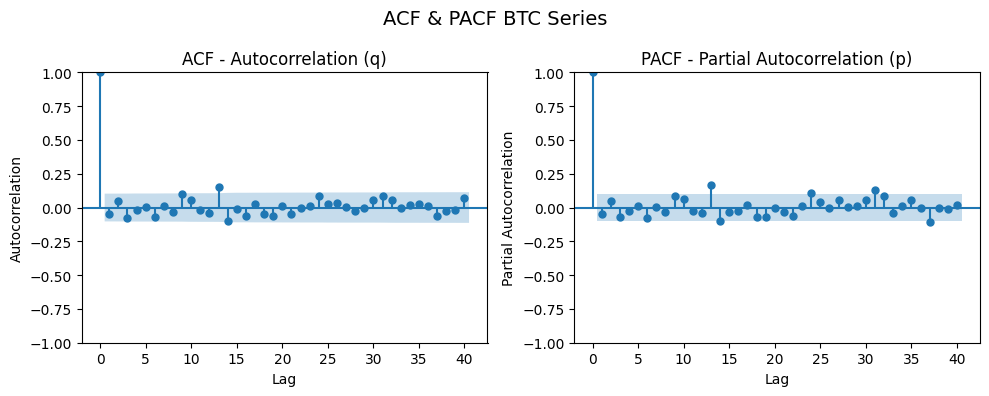

In [188]:
# Plot ACF and PACF using the stationary series
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ACF Plot (for q)
plot_acf(btc_stationary.dropna(), ax=axes[0], lags=40)
axes[0].set_title("ACF - Autocorrelation (q)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(False)

# PACF Plot (for p)
plot_pacf(btc_stationary.dropna(), ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF - Partial Autocorrelation (p)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(False)

# Layout
plt.suptitle("ACF & PACF BTC Series", fontsize=14)
plt.tight_layout()
plt.show()

The autocorrelation function (ACF) and partial autocorrelation function (PACF) plots for the stationary series reveal that autocorrelation drops sharply after the first lag and fluctuates near zero for subsequent lags. Most of the spikes beyond lag 1 lie within the confidence bounds, indicating limited persistence or memory in the series.

These patterns suggest that the immediate past has the strongest influence on the present value, while deeper lags contribute minimally. This behavior is characteristic of a series where short-term dependencies dominate and long-term autocorrelations are weak.